In [1]:
# Read the CSV file
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import numpy as np

file_name = "req_time_x"
file_path = "C:/Users/adity/OneDrive/Desktop/Sixth Semester/CE6018 Seismic Data Analytics/Program/Week7/ReqResampleData/req_time_x.csv"
reqData = pd.read_csv(file_path)
for i in reqData.columns:
    reqData.drop(reqData[(reqData[i] == -999)].index, inplace=True)

reqData.drop(reqData[(reqData["Joyner-Boore Dist. (km)"] == 0)].index, inplace=True)



X_val = ["Earthquake Magnitude",
         "Hypocenter Depth (km)", "Joyner-Boore Dist. (km)", "Vs30 (m/s) selected for analysis"]
Xreq = reqData[X_val]
Xreq["log10(Joyner-Boore Dist. (km))"] = np.log10(Xreq["Joyner-Boore Dist. (km)"])
Xreq["log10(Vs30 (m/s) selected for analysis)"] = np.log10(
    Xreq["Vs30 (m/s) selected for analysis"])

Y_val=["T0.010S", "T0.020S", "T0.022S", "T0.025S", "T0.029S", "T0.030S", "T0.032S", "T0.035S", "T0.036S", "T0.040S", "T0.042S", "T0.044S", "T0.045S", "T0.046S", "T0.048S", "T0.050S", "T0.055S", "T0.060S", "T0.065S", "T0.067S", "T0.070S", "T0.075S", "T0.080S", "T0.085S", "T0.090S", "T0.095S", "T0.100S", "T0.110S", "T0.120S", "T0.130S", "T0.133S", "T0.140S", "T0.150S", "T0.160S", "T0.170S", "T0.180S", "T0.190S", "T0.200S", "T0.220S", "T0.240S", "T0.250S", "T0.260S", "T0.280S", "T0.290S", "T0.300S", "T0.320S", "T0.340S", "T0.350S", "T0.360S", "T0.380S", "T0.400S", "T0.420S", "T0.440S", "T0.450S", "T0.460S", "T0.480S", "T0.500S", "T0.550S", "T0.600S", "T0.650S", "T0.667S", "T0.700S", "T0.750S", "T0.800S", "T0.850S", "T0.900S", "T0.950S", "T1.000S", "T1.100S", "T1.200S", "T1.300S", "T1.400S", "T1.500S", "T1.600S", "T1.700S", "T1.800S", "T1.900S", "T2.000S", "T2.200S", "T2.400S", "T2.500S", "T2.600S", "T2.800S", "T3.000S", "T3.200S", "T3.400S", "T3.500S", "T3.600S", "T3.800S", "T4.000S", "T4.200S", "T4.400S", "T4.600S", "T4.800S", "T5.000S", "T5.500S", "T6.000S", "T6.500S", "T7.000S", "T7.500S", "T8.000S", "T8.500S", "T9.000S", "T9.500S", "T10.000S", "T11.000S", "T12.000S", "T13.000S", "T14.000S", "T15.000S", "T20.000S"
                ]
Yreq = reqData[Y_val]
Yreq_log10 = np.log10(Yreq)

print(Yreq_log10.shape)


# Split data into train and test sets
# Normalizing the data

scalerX = StandardScaler()
scalerY = StandardScaler()
X_normalized = scalerX.fit_transform(Xreq)
Y_normalized = scalerY.fit_transform(Yreq_log10)


dataset_size = len(reqData)
batch_size = 256
train_size = int(dataset_size * 0.85)
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, Y_normalized, test_size=0.2, random_state=42)

print(y_train.shape)

(14017, 111)
(11213, 111)


C:\Users\adity\AppData\Local\Temp\ipykernel_7976\2531387595.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xreq["log10(Joyner-Boore Dist. (km))"] = np.log10(Xreq["Joyner-Boore Dist. (km)"])
C:\Users\adity\AppData\Local\Temp\ipykernel_7976\2531387595.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xreq["log10(Vs30 (m/s) selected for analysis)"] = np.log10(


Using device: cpu
Epoch 1, Loss: 0.1887255853885769, MSE: 0.1887255853885769
Epoch 2, Loss: 0.0946183149461393, MSE: 0.0946183149461393
Epoch 3, Loss: 0.09192407448534612, MSE: 0.09192407448534612
Epoch 4, Loss: 0.09082340172086006, MSE: 0.09082340172086006
Epoch 5, Loss: 0.08975004905733967, MSE: 0.08975004905733967
Epoch 6, Loss: 0.08897309474371097, MSE: 0.08897309474371097
Epoch 7, Loss: 0.08794672333998897, MSE: 0.08794672333998897
Epoch 8, Loss: 0.08755235853697839, MSE: 0.08755235853697839
Epoch 9, Loss: 0.08686508347633218, MSE: 0.08686508347633218
Epoch 10, Loss: 0.0863345076258366, MSE: 0.0863345076258366
Epoch 11, Loss: 0.08601559244329773, MSE: 0.08601559244329773
Epoch 12, Loss: 0.08532149573931327, MSE: 0.08532149573931327
Epoch 13, Loss: 0.08488940302165825, MSE: 0.08488940302165825
Epoch 14, Loss: 0.0844732533365573, MSE: 0.0844732533365573
Epoch 15, Loss: 0.08407807709951685, MSE: 0.08407807709951685
Epoch 16, Loss: 0.08476653808669488, MSE: 0.08476653808669488
Epoch 1

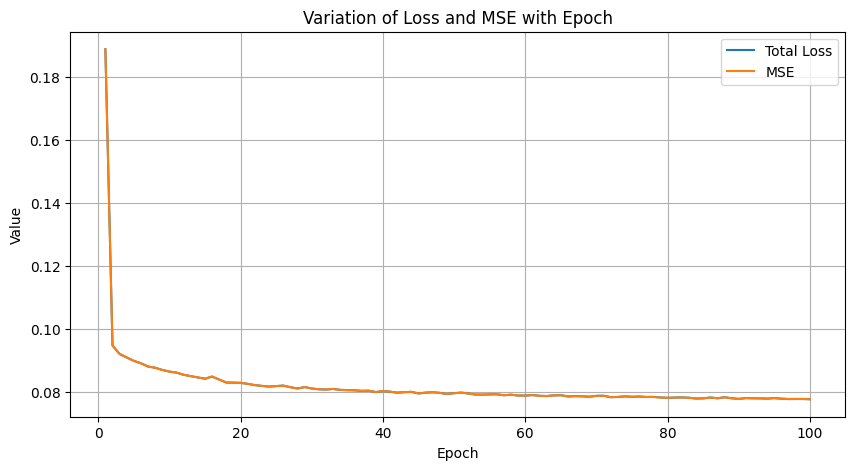

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class BayesianNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BayesianNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ProbabilisticBNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(ProbabilisticBNN, self).__init__()
        self.network = BayesianNetwork(input_dim, hidden_dim, output_dim)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        output = self.network(x)
        return output

    def mc_dropout_forward(self, x, n_samples=20):
        predictions = []
        for _ in range(n_samples):
            with torch.no_grad():
                output = F.dropout(self.network(x), p=self.dropout_rate, training=True)
            predictions.append(output.unsqueeze(0))
        predictions = torch.cat(predictions, dim=0)
        mean_prediction = predictions.mean(dim=0)
        std_prediction = predictions.std(dim=0)
        return mean_prediction, std_prediction

    def kl_divergence(self):
        kl_div = 0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl_div += module.kl_loss()
        return kl_div

def train(model, train_loader, optimizer, criterion, epochs=100):
    model.train()
    mse_values = []
    loss_values = []
    for epoch in range(epochs):
        total_loss = 0
        total_mse = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets) + model.kl_divergence()  # Add KL divergence to the loss
            mse = criterion(outputs, targets).item()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_mse += mse
        avg_loss = total_loss / len(train_loader)
        avg_mse = total_mse / len(train_loader)
        loss_values.append(avg_loss)
        mse_values.append(avg_mse)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}, MSE: {avg_mse}')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), loss_values, label='Total Loss')
    plt.plot(range(1, epochs + 1), mse_values, label='MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Variation of Loss and MSE with Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

def test(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            outputs = model(inputs)
            predictions.extend(outputs.numpy())
            actuals.extend(targets.numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return predictions, actuals

# Example usage:
# Assuming you have input data X_train, y_train, X_test, and y_test

# Convert your data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=32)

# Define model, optimizer, and loss function
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]  # Assuming regression task with single output
hidden_dim = 100
learning_rate = 0.001
dropout_rate = 0.5  # Dropout rate for MC Dropout
model = ProbabilisticBNN(input_dim, hidden_dim, output_dim, dropout_rate)
model = model.to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Train the model
train(model, train_loader, optimizer, criterion, epochs=100)

# Test the model
predictions, actuals = test(model, test_loader)


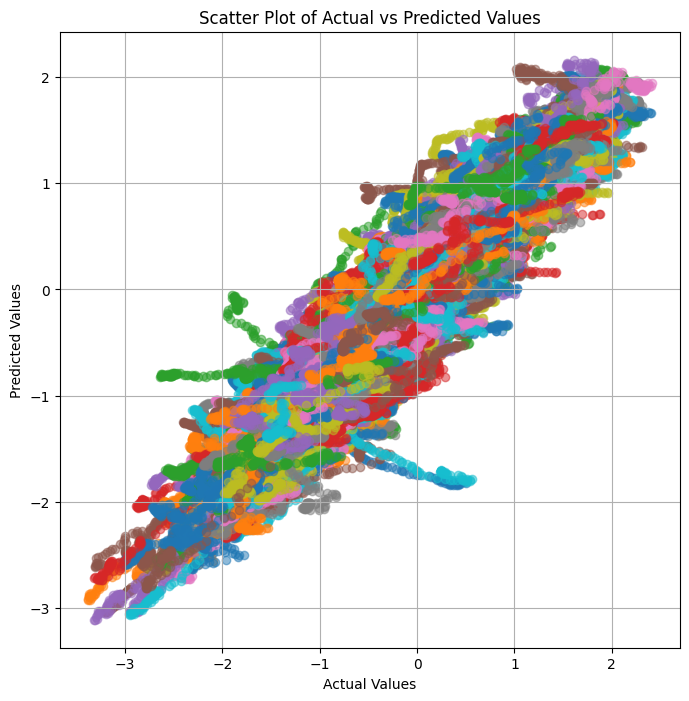

In [3]:
# # Plotting
# plt.figure(figsize=(8, 8))
# plt.scatter(actuals[0], predictions[0], alpha=0.5)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.xscale('log')
# plt.yscale('log')
# plt.title('Scatter Plot of Actual vs Predicted Values')
# plt.grid(True)
# plt.show()


plt.figure(figsize=(8, 8))

# Loop over all subarrays
for i in range(actuals.shape[0]):
    plt.scatter(actuals[i], predictions[i], alpha=0.5)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.grid(True)
plt.show()

Mean Squared Error: 0.08141257613897324
R2 Score: 0.9146277475734812


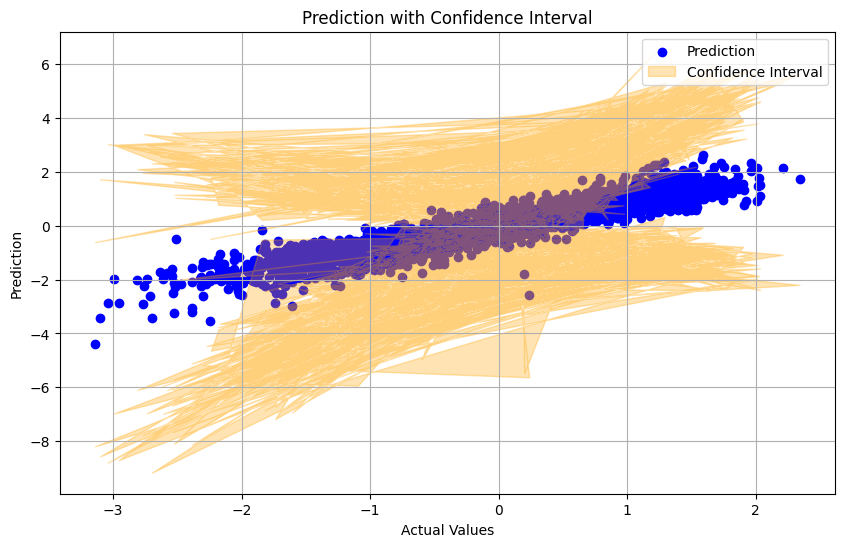

In [4]:

from sklearn.metrics import mean_squared_error, r2_score

# Test the model
predictions, actuals = test(model, test_loader)

# Calculate MSE and R2 score
mse = mean_squared_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Calculation of confidence intervals
mean_predictions, std_predictions = model.mc_dropout_forward(X_test)
confidence_intervals = (mean_predictions - 2 * std_predictions, mean_predictions + 2 * std_predictions)

# Plotting the confidence intervals
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], mean_predictions[:, 0], label='Prediction', color='blue')
plt.fill_between(y_test[:, 0], confidence_intervals[0][:, 0], confidence_intervals[1][:, 0], alpha=0.3, label='Confidence Interval', color='orange')
plt.xlabel('Actual Values')
plt.ylabel('Prediction')
plt.title('Prediction with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()




In [5]:

# print the actual and predicted values with confidence intervals
# for i in range(len(y_test)):
    # print(f'Actual: {y_test[i]}, Predicted: {mean_predictions[i]}, Confidence Interval: {confidence_intervals[0][i]} - {confidence_intervals[1][i]}')


# Convert the tensors to numpy arrays
y_test = y_test.numpy()
mean_predictions = mean_predictions.numpy()
lower_confidence_intervals = confidence_intervals[0].numpy()
upper_confidence_intervals = confidence_intervals[1].numpy()






In [6]:
#converting to actual values
y_test = scalerY.inverse_transform(y_test)
mean_predictions = scalerY.inverse_transform(mean_predictions)
lower_confidence_intervals = scalerY.inverse_transform(lower_confidence_intervals)
upper_confidence_intervals = scalerY.inverse_transform(upper_confidence_intervals)

# Get the number of columns
# num_columns = actuals.shape[1]

# # Create a list of column names
# column_names = [f"Column {i+1}" for i in range(num_columns)]

Ytestdf= pd.DataFrame(y_test, columns=Y_val)
Ypreddf= pd.DataFrame(mean_predictions, columns=Y_val)
Ylowerdf= pd.DataFrame(lower_confidence_intervals, columns=Y_val)
Yupperdf= pd.DataFrame(upper_confidence_intervals, columns=Y_val)

In [7]:
#Making a data frame having actual , predicted and confidence interval values for each column
finalDf=pd.DataFrame({f"Actual_{Y_val[0]}":Ytestdf[Y_val[0]], f"Predicted_{Y_val[0]}":Ypreddf[Y_val[0]], f"Lower Confidence Interval_{Y_val[0]}":Ylowerdf[Y_val[0]], f"Upper Confidence Interval_{Y_val[0]}":Yupperdf[Y_val[0]]})
for i in range(len(Y_val)-1):
    finalDf=pd.concat([finalDf,pd.DataFrame({f"Actual_{Y_val[i+1]}":Ytestdf[Y_val[i+1]], f"Predicted_{Y_val[i+1]}":Ypreddf[Y_val[i+1]], f"Lower Confidence Interval_{Y_val[i+1]}":Ylowerdf[Y_val[i+1]], f"Upper Confidence Interval_{Y_val[i+1]}":Yupperdf[Y_val[i+1]]})], axis=1,join='inner')

# Save the data frame to a CSV file
# finalDf.to_csv("C:/Users/adity/OneDrive/Desktop/Sixth Semester/CE6018 Seismic Data Analytics/Program/Week8/BNNresult/Result.csv", index=False)



In [8]:
#calculate and print the epistemix uncertainty and aleatoric uncertainty
epistemic_uncertainty_Total = torch.mean(std_predictions**2)
aleatoric_uncertainty_Total = np.mean(np.exp(model.network.fc2.weight.detach().numpy())**2)
print(f'Epistemic Uncertainty: {epistemic_uncertainty_Total}')
print(f'Aleatoric Uncertainty: {aleatoric_uncertainty_Total}')

Epistemic Uncertainty: 0.8727890253067017
Aleatoric Uncertainty: 1.0628169775009155


In [9]:
# Calculate the epistemic and aleatoric uncertainty for individual columns
epistemic_uncertainty = (std_predictions**2).numpy()
aleatoric_uncertainty = np.exp(model.network.fc2.weight.detach().numpy())**2

# Print the shapes of the epistemic and aleatoric uncertainty
print(aleatoric_uncertainty.shape)
print(epistemic_uncertainty.shape)

# Create a data frame for epistemic and aleatoric uncertainty
Epistemicdf=pd.DataFrame(epistemic_uncertainty, columns=Y_val)
Aleatoricdf=pd.DataFrame(np.transpose(aleatoric_uncertainty), columns=Y_val)



UncertainityStats = pd.DataFrame({"Parameters": [x for x in Y_val]})
UncertainityStats = pd.concat([UncertainityStats, pd.DataFrame(
    {"aleatoric_uncertainty": [Aleatoricdf[x].mean() for x in Aleatoricdf.columns]})], axis=1, join="inner")
UncertainityStats = pd.concat([UncertainityStats, pd.DataFrame(
    {"epistemic_uncertainty": [Epistemicdf[x].mean() for x in Epistemicdf.columns]})], axis=1, join="inner")
UncertainityStats.to_csv("C:/Users/adity/OneDrive/Desktop/Sixth Semester/CE6018 Seismic Data Analytics/Program/Week8/BNNresult/UncertainityStats.csv", index=False)
UncertainityStats



()
()


ValueError: DataFrame constructor not properly called!

In [ ]:
#Saving the model to a file
# torch.save(model.state_dict(), "C:/Users/adity/OneDrive/Desktop/Sixth Semester/CE6018 Seismic Data Analytics/Program/Week8/BNNresult/BNNModel_Response_Spectra.pth")